### Midterm Project - Oil and Water Rate Production using XGBoost Regression

In [ ]:
!pip install kaggle xgboost seaborn shap openpyxl

In [2]:
# Import library

import pandas as pd
import numpy as np
import pickle
import requests

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

import shap

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/workspaces/machine_learning_zoomcamp/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Load dataset
df = pd.read_excel('/workspaces/machine_learning_zoomcamp/Midterm_Project/data/Volve production data.xlsx', sheet_name='Daily Production Data', parse_dates=True)
df.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


### Data Preprocessing
From here, in the Data Preprocessing, for Volve dataset, I am going to do several tasks including:
- Well selection
- NaN Removal
- Skewness Analysis

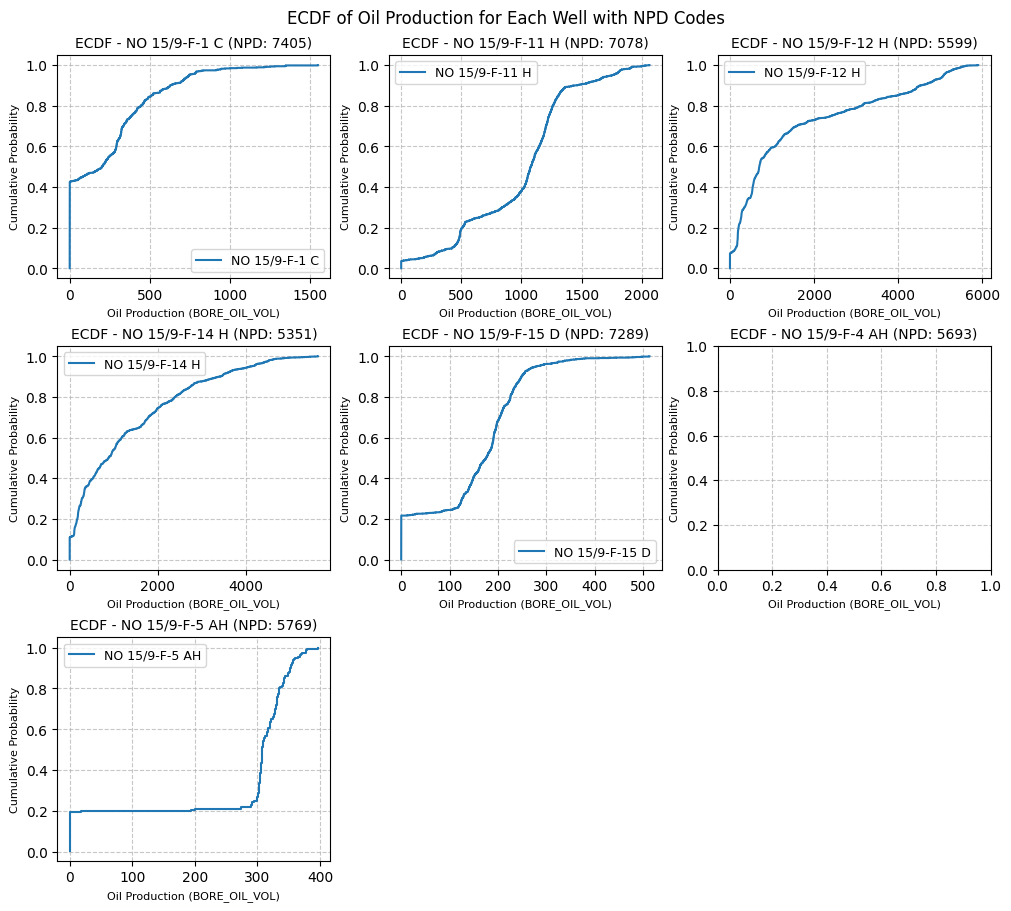

In [6]:
# Oil Volume Production
well_names = df['WELL_BORE_CODE'].unique()
well_code_map = df.set_index('WELL_BORE_CODE')['NPD_WELL_BORE_CODE'].to_dict()

# Determine the number of subplots
num_wells = len(well_names)
cols = 3 
rows = -(-num_wells // cols)

# Initialize the subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, rows * 3), constrained_layout=True)
axes = axes.flatten()

for i, well in enumerate(well_names):
    well_data = df[df['WELL_BORE_CODE'] == well]['BORE_OIL_VOL'].dropna()
    ax = axes[i]
    if len(well_data) > 0: 
        x = np.sort(well_data)
        y = np.arange(1, len(x) + 1) / len(x)
        ax.step(x, y, where="post", label=f"{well}")
        ax.legend(fontsize=9)
    npd_code = well_code_map.get(well, "Unknown")
    ax.set_title(f"ECDF - {well} (NPD: {npd_code})", fontsize=10)
    ax.set_xlabel("Oil Production (BORE_OIL_VOL)", fontsize=8)
    ax.set_ylabel("Cumulative Probability", fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.7)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("ECDF of Oil Production for Each Well with NPD Codes", fontsize=12)
plt.show()

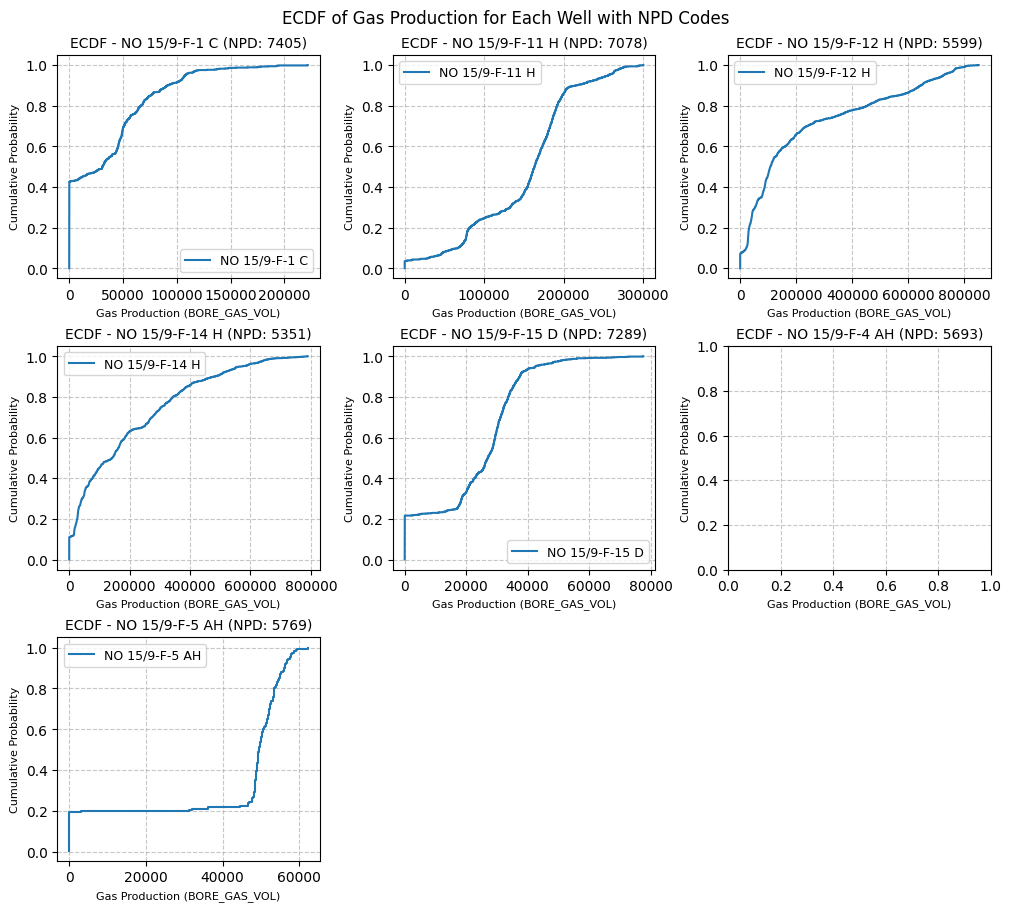

In [7]:
# Gas Production Volume
well_names = df['WELL_BORE_CODE'].unique()
well_code_map = df.set_index('WELL_BORE_CODE')['NPD_WELL_BORE_CODE'].to_dict()

# Determine the number of subplots needed
num_wells = len(well_names)
cols = 3 
rows = -(-num_wells // cols)

# Initialize the subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, rows * 3), constrained_layout=True)
axes = axes.flatten()

for i, well in enumerate(well_names):
    well_data = df[df['WELL_BORE_CODE'] == well]['BORE_GAS_VOL'].dropna()
    ax = axes[i]
    if len(well_data) > 0:
        x = np.sort(well_data)
        y = np.arange(1, len(x) + 1) / len(x)
        ax.step(x, y, where="post", label=f"{well}")
        ax.legend(fontsize=9)
    npd_code = well_code_map.get(well, "Unknown")
    ax.set_title(f"ECDF - {well} (NPD: {npd_code})", fontsize=10)
    ax.set_xlabel("Gas Production (BORE_GAS_VOL)", fontsize=8)
    ax.set_ylabel("Cumulative Probability", fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.7)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("ECDF of Gas Production for Each Well with NPD Codes", fontsize=12)
plt.show()

Since the data contains different wells name, for this midterm project, only several wells will be used for the machine learning model. The selected wells will be only producing wells indicated by the ECDF visualizations with minimum null values.

As described of oil and gas production data, there are only five wells that is actually producing the hydrocarbon (gas and oil) which are including:
- NO 15/9-F-15 D
- NO 15/9-F-14 H
- NO 15/9-F-1 C
- NO 15/9-F-11 H
- NO 15/9-F-12 H

In [8]:
# Filtered data
df_new = df[df["WELL_BORE_CODE"].isin(['NO 15/9-F-14 H', 'NO 15/9-F-15 D', 'NO 15/9-F-11 H', 'NO 15/9-F-12 H'])]
df_new.columns = df.columns.str.lower().str.replace(' ', '_')
df_new.reset_index(drop=True, inplace=True)

# Calculate oil and water rates
df_new["oil_rate"] = (df_new["bore_oil_vol"] / df_new["on_stream_hrs"])
df_new["water_rate"] = (df_new["bore_wat_vol"] / df_new["on_stream_hrs"])

df_new["oil_rate"] = df_new["oil_rate"].replace(np.inf, 0)
df_new["water_rate"] = df_new["water_rate"].replace(np.inf, 0)

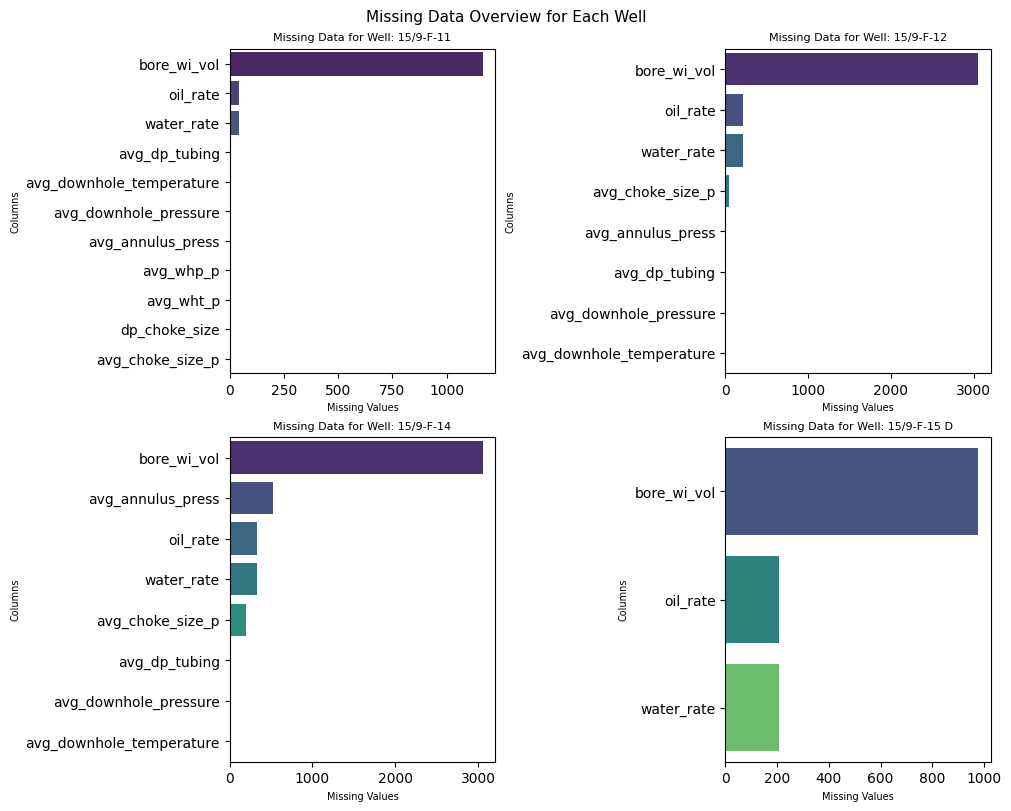

In [9]:
well_names = df_new['npd_well_bore_name'].unique()
num_wells = len(well_names)
cols = 2 
rows = -(-num_wells // cols)

# Initialize subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, rows * 4), constrained_layout=True)
axes = axes.flatten()

for i, well in enumerate(well_names):
    well_data = df_new[df_new['npd_well_bore_name'] == well]
    missing_data = well_data.isnull().sum()
    missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

    ax = axes[i]
    sns.barplot(x=missing_data.values, y=missing_data.index, palette="viridis", ax=ax)
    ax.set_title(f"Missing Data for Well: {well}", fontsize=8)
    ax.set_xlabel("Missing Values", fontsize=7)
    ax.set_ylabel("Columns", fontsize=7)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Missing Data Overview for Each Well", fontsize=11)
plt.show()

As described in the above missing data charts, some of wells might have null values for certain column variables but since it is a producing well, all wells do not have any data in the bore_wi_vol (water injection volume), therefore, it will be removed.

In [10]:
# Cleaning unused column
df_new = df_new.drop(columns=['well_bore_code', 'npd_well_bore_code', 'npd_field_code', 'npd_field_name', 'npd_facility_code',
                              'npd_facility_name', 'bore_wi_vol', 'flow_kind', 'well_type', 'avg_choke_uom'])

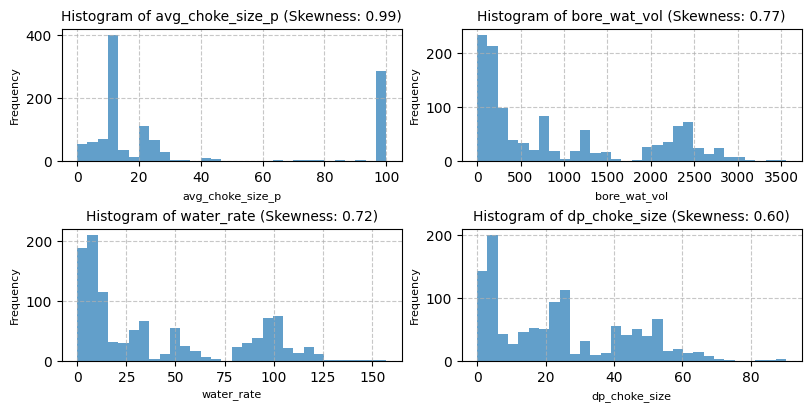

In [11]:
# Filter data for a specific well
selected_well = "15/9-F-11"
filtered_data = df_new[df_new['npd_well_bore_name'] == selected_well]

# Calculate skewness for numerical columns
numerical_columns = filtered_data.select_dtypes(include=['float64', 'int64']).columns
skewness = filtered_data[numerical_columns].skew().sort_values(ascending=False)

skewness_df = skewness.reset_index()
skewness_df.columns = ['Column', 'Skewness']
skewed_columns = skewness[skewness > 0.5].index

num_columns = len(skewed_columns)
cols = 2 
rows = -(-num_columns // cols)

fig, axes = plt.subplots(rows, cols, figsize=(8, rows * 2), constrained_layout=True)
axes = axes.flatten()

# Plot histograms for each skewed column
for i, column in enumerate(skewed_columns):
    filtered_data[column].dropna().hist(bins=30, ax=axes[i], alpha=0.7)
    axes[i].set_title(f"Histogram of {column} (Skewness: {skewness[column]:.2f})", fontsize=10)
    axes[i].set_xlabel(column, fontsize=8)
    axes[i].set_ylabel("Frequency", fontsize=8)
    axes[i].grid(True, linestyle='--', alpha=0.7)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

Based on skewness analysis and missing values calculation, the results show that the data are skewed but since the normal condition from the field is unknown, there is no value removal for current model development. Next is fill the Nan values and remove NaN if available

In [12]:
# Select only numeric columns and apply forward fill
numeric_columns = df_new.select_dtypes(include=['float64', 'int64']).columns
df_new[numeric_columns] = df_new[numeric_columns].fillna(method='ffill')

# Remove remaining Null Values
df_new = df_new.dropna(axis=0).reset_index(drop=True)

In [13]:
df_new.dtypes

dateprd                     datetime64[ns]
npd_well_bore_name                  object
on_stream_hrs                      float64
avg_downhole_pressure              float64
avg_downhole_temperature           float64
avg_dp_tubing                      float64
avg_annulus_press                  float64
avg_choke_size_p                   float64
avg_whp_p                          float64
avg_wht_p                          float64
dp_choke_size                      float64
bore_oil_vol                       float64
bore_gas_vol                       float64
bore_wat_vol                       float64
oil_rate                           float64
water_rate                         float64
dtype: object

### Exploratory Data Analysis
In the Exploratory Data Analysis (EDA), two ways will be run include Correlation Matrix and Boxplot

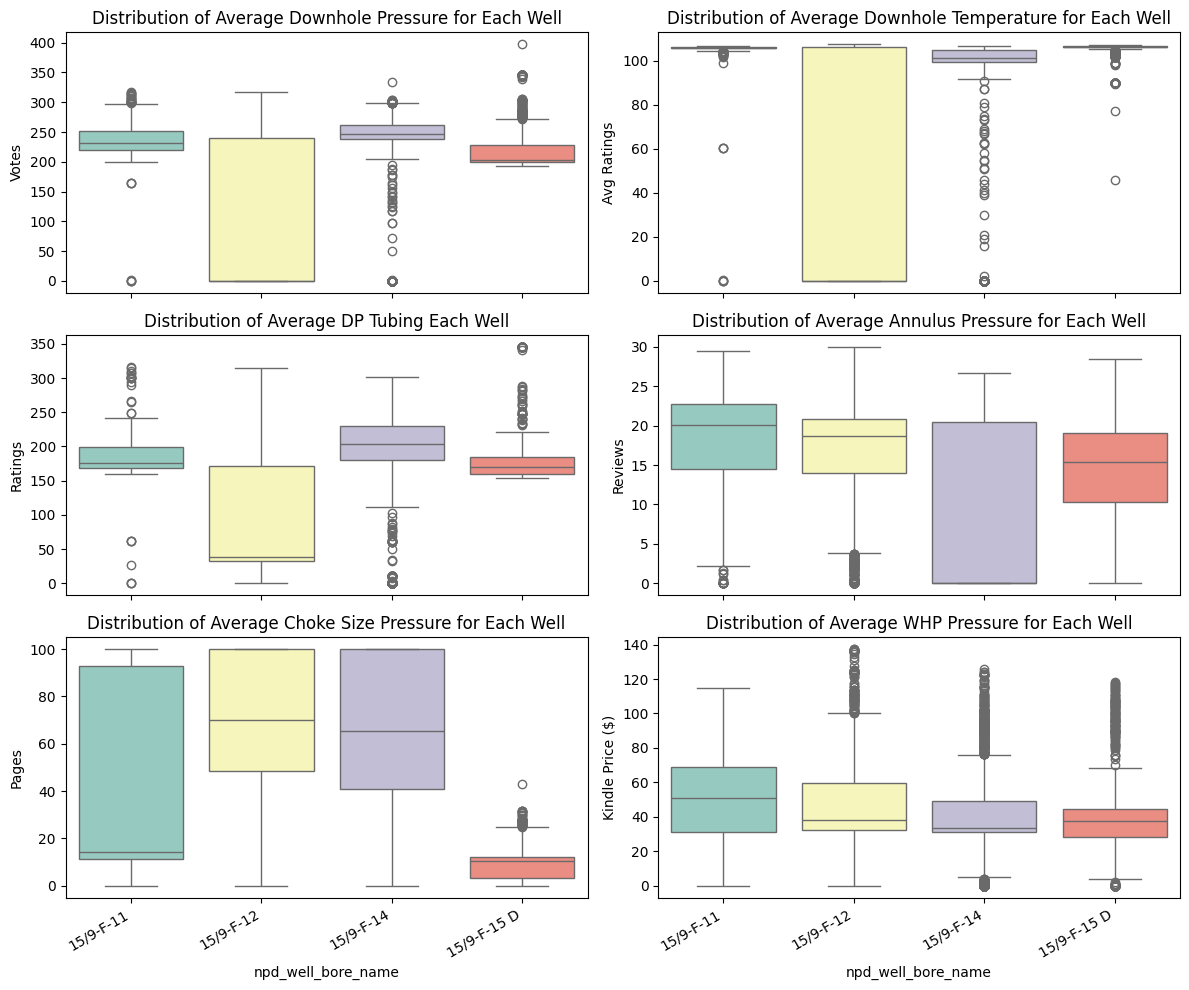

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharey=False, sharex=True)

# First plot Distribution of Average Downhole Pressure
sns.boxplot(data=df_new, x='npd_well_bore_name', y='avg_downhole_pressure', palette='Set3', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Average Downhole Pressure for Each Well')
axes[0, 0].set_ylabel('Votes')

# Second plot Distribution of Average Downhole Temperature
sns.boxplot(data=df_new, x='npd_well_bore_name', y='avg_downhole_temperature', palette='Set3', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Average Downhole Temperature for Each Well')
axes[0, 1].set_ylabel('Avg Ratings')

# Third plot Distribution of Average Discharge Pressure Tubing
sns.boxplot(data=df_new, x='npd_well_bore_name', y='avg_dp_tubing', palette='Set3', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Average DP Tubing Each Well')
axes[1, 0].set_ylabel('Ratings')

# Fourth plot Distribution of Annulus Pressure
sns.boxplot(data=df_new, x='npd_well_bore_name', y='avg_annulus_press', palette='Set3', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Average Annulus Pressure for Each Well')
axes[1, 1].set_ylabel('Reviews')

# Fifth plot Distribution of Choke Size Pressure
sns.boxplot(data=df_new, x='npd_well_bore_name', y='avg_choke_size_p', palette='Set3', ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Average Choke Size Pressure for Each Well')
axes[2, 0].set_ylabel('Pages')

# Sixth plot Distribution of WHP Pressure
sns.boxplot(data=df_new, x='npd_well_bore_name', y='avg_whp_p', palette='Set3', ax=axes[2, 1])
axes[2, 1].set_title('Distribution of Average WHP Pressure for Each Well')
axes[2, 1].set_ylabel('Kindle Price ($)')

for ax in axes[2, :]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    
fig.tight_layout()
plt.show()

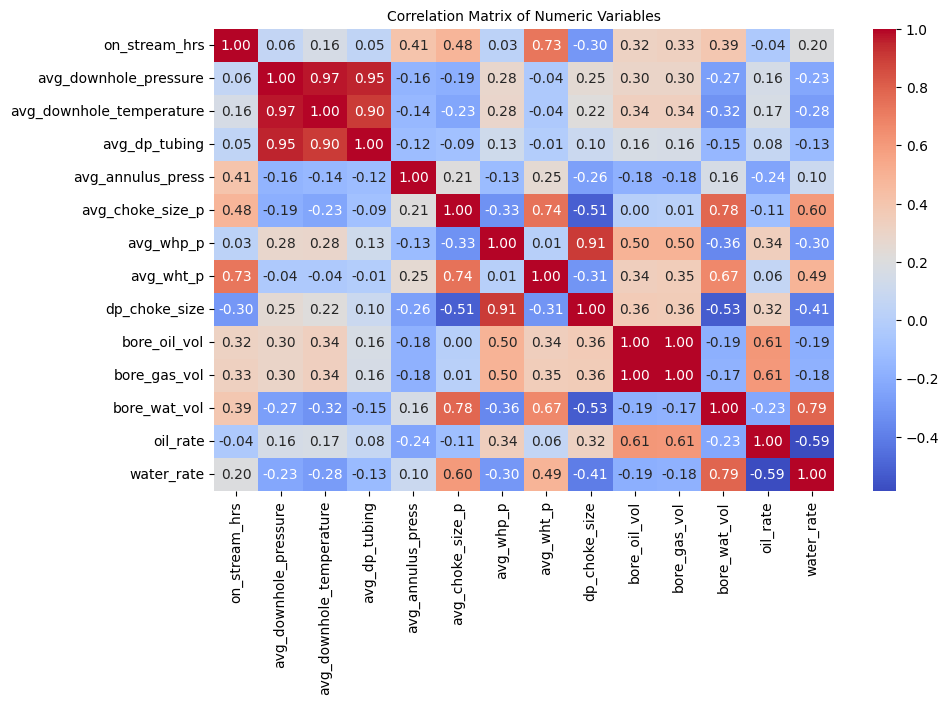

In [16]:
# Calculate the correlation matrix for numeric columns
numeric_data = df_new.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Numeric Variables", fontsize=10)
plt.show()

The correlation result shows that bore_oil_vol and bore_gas_vol have perfect correlation. However, since we want to measure production, using the variable will be ambiguous since it is impossible to get gas production (bore_gas_vol) before the oil production (bore_oil_vol) volume.

In addition, **avg_downhole_pressure** with **avg_downhole_temperature** and **avg_dp_tubing** have high correlation as well. In terms of modeling, the high correlation might affect the model result. Therefore, one of these parameters should be selected and for this instance, **avg_downhole_pressure** is selected.

In [17]:
# Final dataset after Feature Selection
df_final = df_new.drop(columns=['bore_oil_vol', 'bore_wat_vol', 'on_stream_hrs', 'avg_downhole_temperature', 'avg_dp_tubing', 'bore_gas_vol'])

View Target Model: Oil and Water Rate

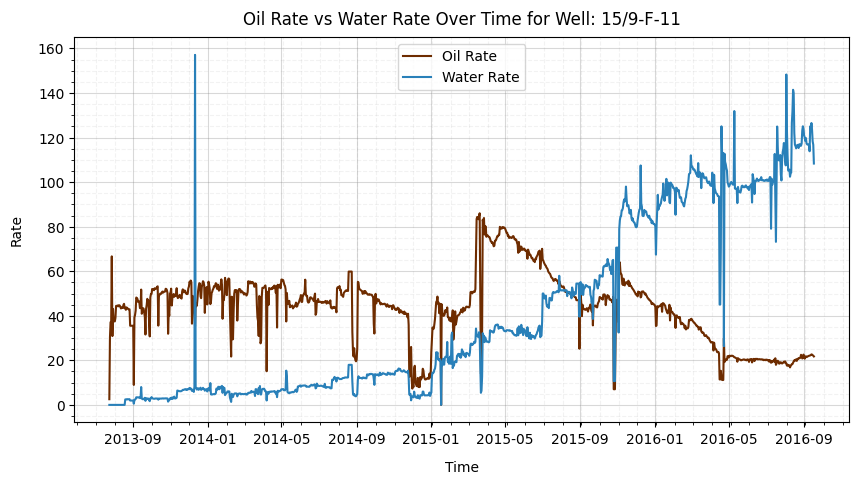

In [18]:
# Oil Rate vs Water Rate with Time
selected_well = "15/9-F-11"  # Example well name
filtered_data = df_final[df_final["npd_well_bore_name"] == selected_well]

# Plot production rates
plt.figure(figsize=(10, 5))

# Plot oil rate and water rate
plt.plot(filtered_data["dateprd"], filtered_data["oil_rate"], color="#6E2C00", label="Oil Rate")
plt.plot(filtered_data["dateprd"], filtered_data["water_rate"], color="#2980B9", label="Water Rate")

# Set axis labels
plt.xlabel("Time", fontsize=10, labelpad=10)
plt.ylabel("Rate", fontsize=10, labelpad=10)

# Set plot title
plt.title(f"Oil Rate vs Water Rate Over Time for Well: {selected_well}", fontsize=12, pad=10)

# Add grid
plt.grid(which="major", linestyle="-", alpha=0.3, color="gray")
plt.minorticks_on()
plt.grid(which="minor", linestyle="--", alpha=0.1, color="gray")

# Add legend
plt.legend(fontsize=10)

# Show the plot
plt.show()

In [19]:
df_final.head()

,dateprd,npd_well_bore_name,avg_downhole_pressure,avg_annulus_press,avg_choke_size_p,avg_whp_p,avg_wht_p,dp_choke_size,oil_rate,water_rate
0,2013-07-24,15/9-F-11,1.92627,2.88536,3.256548,28.04931,18.19463,18.85147,2.550000,0.0
1,2013-07-25,15/9-F-11,163.59426,19.46451,8.549131,102.12118,36.96744,72.95519,30.208333,0.0
2,2013-07-26,15/9-F-11,163.59426,19.46451,9.419192,102.12118,36.96744,72.95519,37.145000,0.0
3,2013-07-27,15/9-F-11,163.59426,19.46451,9.322098,102.12118,36.96744,72.95519,36.934167,0.0
4,2013-07-28,15/9-F-11,0.00000,0.00000,2.464222,0.00000,0.00000,0.00000,66.678571,0.0


### Model Development

In [20]:
# Split dataset
features = ['avg_annulus_press', 'avg_choke_size_p', 'avg_wht_p', 'avg_downhole_pressure', 'avg_whp_p', 'dp_choke_size']
X = df_final[features]

# Targets for prediction
y = df_final[['oil_rate', 'water_rate']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# Display the split data sizes
print(f'Training set size: {X_train.shape}, Testing set size: {X_test.shape}')

Training set size: (6591, 6), Testing set size: (1648, 6)


#### First Model Test - Linear Regression

In [21]:
from sklearn.linear_model import LinearRegression

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model on the training data
lr_model.fit(X_train, y_train)

# Display coefficients and intercepts
print("Model Coefficients:", lr_model.coef_)
print("Model Intercept:", lr_model.intercept_)

Model Coefficients: [[-2.07227495 -0.32845594  1.00886687  0.0214383  -0.24144205  1.34445249]
 [-0.65547894  0.87924688  0.92873463 -0.08119985 -1.01825084  0.51053015]]
Model Intercept: [17.3148624  26.28407599]


In [22]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on the testing set
y_pred = lr_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 3661.549721355829
R² Score: 0.3516889231443776


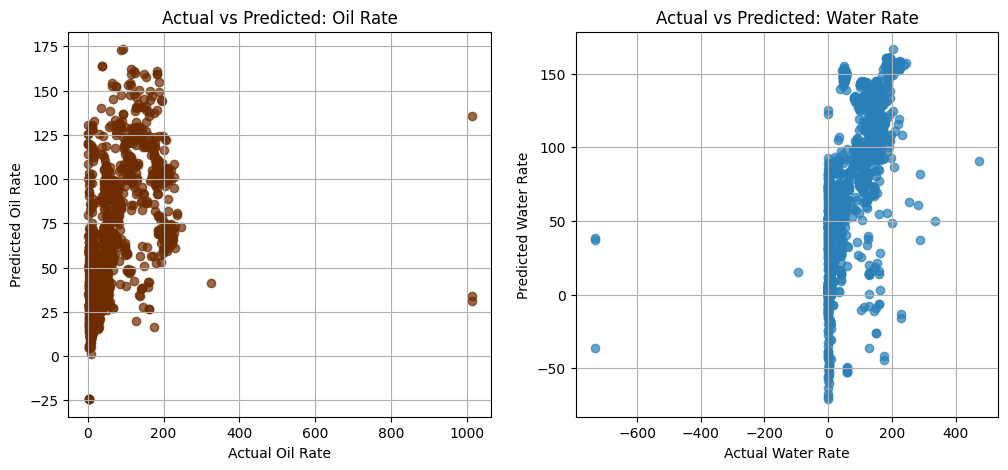

In [23]:
# Plot actual vs predicted for oil rate
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test["oil_rate"], y_pred[:, 0], alpha=0.7, color="#6E2C00")
plt.title("Actual vs Predicted: Oil Rate")
plt.xlabel("Actual Oil Rate")
plt.ylabel("Predicted Oil Rate")
plt.grid()

# Plot actual vs predicted for water rate
plt.subplot(1, 2, 2)
plt.scatter(y_test["water_rate"], y_pred[:, 1], alpha=0.7, color="#2980B9")
plt.title("Actual vs Predicted: Water Rate")
plt.xlabel("Actual Water Rate")
plt.ylabel("Predicted Water Rate")
plt.grid()
plt.show()

The R2 value for linear regression for oil rate production in well 15/9-F-14 is -92.6697915375499


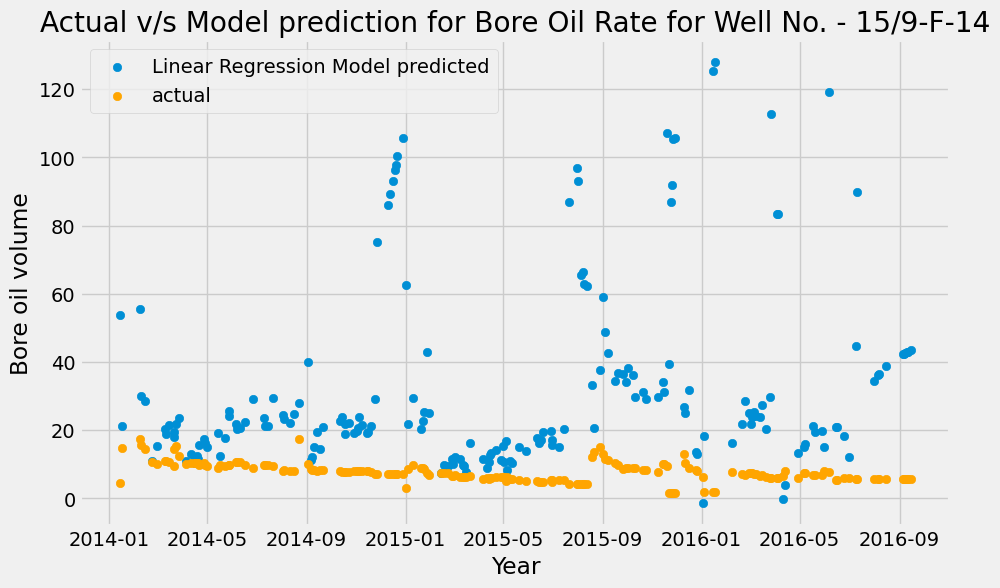

In [24]:
df_159F14 = df_final[df_final["npd_well_bore_name"] == '15/9-F-15 D']

features = ['avg_annulus_press', 'avg_choke_size_p', 'avg_wht_p', 'avg_downhole_pressure', 'avg_whp_p', 'dp_choke_size', 'dateprd']

X = df_159F14[features]

# Targets for prediction
y = df_159F14[['oil_rate', 'water_rate']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

X_test_159F14 = X_test.drop(['dateprd'], axis=1)

y_linear = lr_model.predict(X_test_159F14)

plt.style.use('fivethirtyeight')
plt.figure(figsize = (10,6))
plt.scatter(X_test['dateprd'].tolist(),y_linear[:,0],label='Linear Regression Model predicted')
plt.scatter(X_test['dateprd'].tolist(),y_test['oil_rate'],label='actual', color = 'orange')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Bore oil volume")
plt.title('Actual v/s Model prediction for Bore Oil Rate for Well No. - 15/9-F-14')

print("The R2 value for linear regression for oil rate production in well 15/9-F-14 is", lr_model.score(X_test_159F14,y_test))

#### Second Model Test - XGBoost

In [25]:
# XGBoost Model
from xgboost import XGBRegressor

In [27]:
# Split dataset
# Include 'days' in the list of features
features = ['avg_annulus_press', 'avg_choke_size_p', 'avg_wht_p', 'avg_downhole_pressure', 'avg_whp_p', 'dp_choke_size']
X = df_final[features]

# Targets for prediction
y = df_final[['oil_rate', 'water_rate']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# Display the split data sizes
print(f'Training set size: {X_train.shape}, Testing set size: {X_test.shape}')

Training set size: (6591, 6), Testing set size: (1648, 6)


In [30]:
xgb = XGBRegressor(max_depth=10,n_estimators=1000,objective="reg:squarederror")
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
def eval(model):
    # get the mean absolute error
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    oil_mae = mean_absolute_error(y_test["oil_rate"],y_pred[:,0])
    oil_r2 = r2_score(y_test["oil_rate"],y_pred[:,0])
    water_mae = mean_absolute_error(y_test["water_rate"],y_pred[:,1])
    water_r2 = r2_score(y_test["water_rate"],y_pred[:,1])
    print(f" Oil MAE :{oil_mae} , R2 :{oil_r2}")
    print(f" Water MAE :{water_mae} , R2 :{water_r2}")

In [31]:
# Test on XGB Model
eval(xgb)

 Oil MAE :5.429469829164317 , R2 :0.6741908750627352
 Water MAE :8.463306672136545 , R2 :0.7253181659063025


#### Feature Importance

In [32]:
features = ['avg_annulus_press', 'avg_choke_size_p', 'avg_wht_p', 'avg_downhole_pressure', 'avg_whp_p', 'dp_choke_size']
# Get feature importances
feature_importances = xgb.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Display the feature importance
print(importance_df)

                 Feature  Importance
2              avg_wht_p    0.330596
4              avg_whp_p    0.290532
3  avg_downhole_pressure    0.181749
0      avg_annulus_press    0.093962
1       avg_choke_size_p    0.071206
5          dp_choke_size    0.031954


The R2 value for linear regression for oil rate production in well 15/9-F-14 is 0.8851686120033264


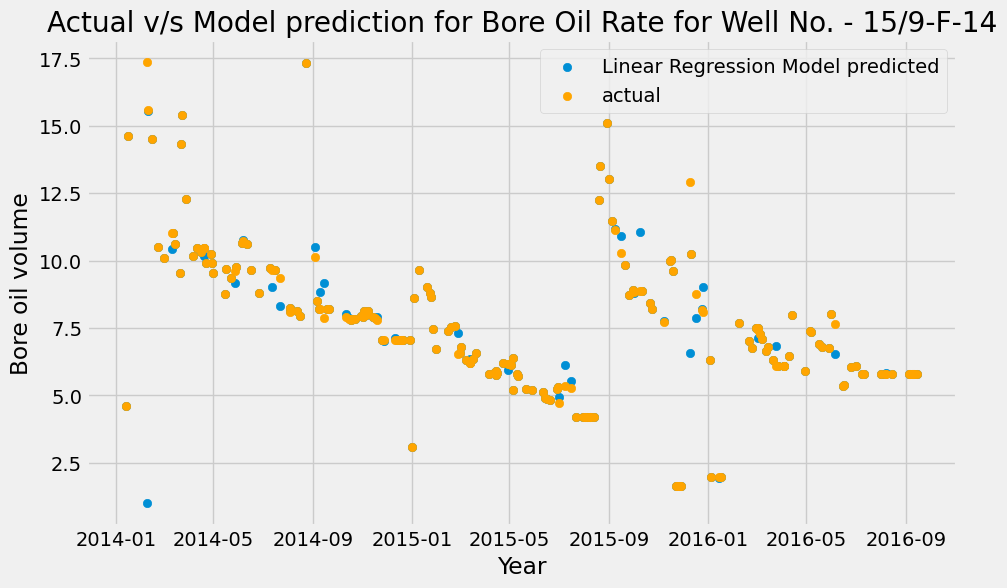

In [33]:
# Predicted vs Original Value on Each Wells
df_159F15D = df_final[df_final["npd_well_bore_name"] == '15/9-F-15 D']

features = ['avg_annulus_press', 'avg_choke_size_p', 'avg_wht_p', 'avg_downhole_pressure', 'avg_whp_p', 'dp_choke_size', 'dateprd']

X = df_159F15D[features]

# Targets for prediction
y = df_159F15D[['oil_rate', 'water_rate']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

X_test_159F15D = X_test.drop(['dateprd'], axis=1)

y_linear = xgb.predict(X_test_159F15D)

plt.style.use('fivethirtyeight')
plt.figure(figsize = (10,6))
plt.scatter(X_test['dateprd'].tolist(),y_linear[:,0],label='Linear Regression Model predicted')
plt.scatter(X_test['dateprd'].tolist(),y_test['oil_rate'],label='actual', color = 'orange')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Bore oil volume")
plt.title('Actual v/s Model prediction for Bore Oil Rate for Well No. - 15/9-F-14')

print("The R2 value for linear regression for oil rate production in well 15/9-F-14 is", xgb.score(X_test_159F15D,y_test))